# Neural Network

Goals of this notebook: 
- Test the performance of a neural network in classifying if a loan was paid off or not
- Try some hyper-parameter tuning to determine optimal parameters for the different models?
- Experiment with different neural network architectures

In [43]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from torchvision import datasets, transforms

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting
from bokeh.layouts import column, row
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
bokeh.io.output_notebook()

Loading BokehJS ...

#### Load the data, normalize, and split into a training and validation set

In [71]:
def min_max_data_normalize(data_train, data_test):
    data_min = data_train.min()
    data_max = data_train.max()
    normal_data_train = (data_train - data_min) / (data_max - data_min)
    normal_data_test = (data_test - data_min) / (data_max - data_min)
    
    return normal_data_train, normal_data_test

def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train = pd.read_csv("data/2022-02-06_LOANS_TRAIN.csv")
    data_test = pd.read_csv("data/2022-02-06_LOANS_TEST.csv")
    y_train = data_train['loan_status']
    data_train.drop('loan_status', 1, inplace=True)
    normal_data_train, normal_data_test = min_max_data_normalize(data_train, data_test)
    
    return normal_data_train, normal_data_test, y_train

def to_submission(y_test_predicted_probability):
    y_test = pd.DataFrame(y_test_predicted_probability, columns=['loan_status'])
    y_test.to_csv('data/submission.csv', index_label='id')
    return

In [72]:
X_train, X_test, y_train = data_processed()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_val shape: {X_val.shape}
y_val shape: {y_val.shape}
""")

/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_10485/493885001.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('loan_status', 1, inplace=True)



X_train shape: (132157, 29)
y_train shape: (132157,)
X_val shape: (65093, 29)
y_val shape: (65093,)



In [73]:
# change to one hot encoding
y_train, y_val = to_categorical(y_train), to_categorical(y_val)

Write function to plot training history

In [11]:
def plot_results(history):
    tools = [PanTool(), WheelZoomTool(), ResetTool(), HoverTool()]
    p = bokeh.plotting.figure(title='Training and validation loss', tools=tools)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    p.line(epochs, loss, color='blue', legend_label='Training loss')
    p.line(epochs, val_loss, color='red', legend_label='Validation loss')
    p.yaxis.axis_label = "Loss"
    p.xaxis.axis_label = 'Epochs'
    p.legend.click_policy="hide"
    p.legend.visible=False

    q = bokeh.plotting.figure(title='Training and validation accuracy', tools=tools)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    q.line(epochs, acc, color='blue', legend_label='training')
    q.line(epochs, val_acc, color='red', legend_label='validation')
    q.yaxis.axis_label = "Accuracy"
    q.xaxis.axis_label = 'Epochs'
    q.legend.click_policy="hide"
    q.legend.location="bottom_right"
    bokeh.io.show(row(p, q))

#### Experiment 1a:

In [16]:
network = models.Sequential()
network.add(layers.Dense(200, activation="sigmoid", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(50, activation="sigmoid"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [17]:
history = network.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1, shuffle=True, verbose=False)

In [18]:
test_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 2s 1ms/step - loss: 0.4040 - accuracy: 0.8466
the final accuracy on the holdout set was  84.66 %


In [19]:
y_pred = network.predict(X_val)

In [22]:
roc_auc_score(y_val, y_pred)

0.6791465207494087

In [23]:
plot_results(history)

#### Experiment 2a:

In [35]:
network = models.Sequential()
network.add(layers.Dense(300, activation="relu", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(100, activation="relu"))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(50, activation="relu"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [36]:
history = network.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1, shuffle=True, verbose=False)

In [37]:
test_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 3s 1ms/step - loss: 0.4022 - accuracy: 0.8466
the final accuracy on the holdout set was  84.66 %


In [38]:
y_pred = network.predict(X_val)
roc_auc_score(y_val, y_pred)

0.6806843098334024

In [39]:
plot_results(history)

### Experiment 3a:

In [74]:
network = models.Sequential()
network.add(layers.Dense(400, activation="relu", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.4))
network.add(layers.Dense(200, activation="relu"))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(100, activation="relu"))
network.add(layers.Dense(10, activation="relu"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [75]:
history = network.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, shuffle=True, verbose=False)

In [76]:
test_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 3s 1ms/step - loss: 0.4018 - accuracy: 0.8466
the final accuracy on the holdout set was  84.66 %


In [77]:
y_pred = network.predict(X_val)
roc_auc_score(y_val, y_pred)

0.680913944700968

In [78]:
plot_results(history)

## Implement PCA upstream of neural networks

Plot the cumulative variance versus the number of components to get information about the explained variance

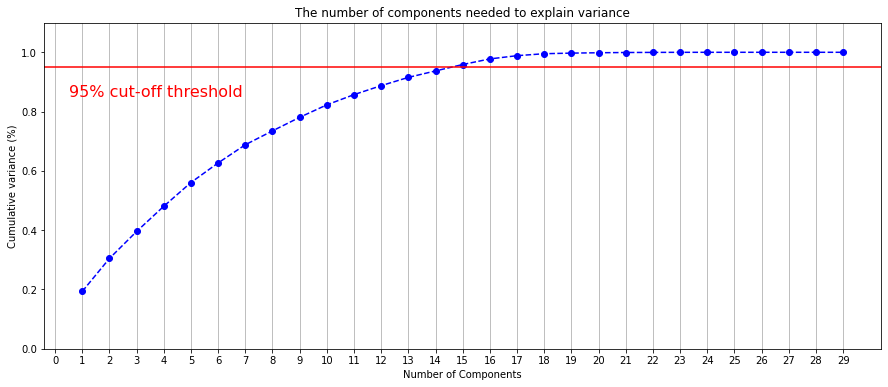

In [79]:
pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 30, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 30, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#### We want to select a number of components that captures 95% explained variance. We don't need to infer from the above graph what that value would be - the sklearn implementation allows you to define the desired explained variance using the `n_components` argument for the PCA function.

In [80]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)

Apply the same transform to the test data

In [81]:
X_val = pca.transform(X_val)

#### Now, repeat the experiments with the PCA transformed data

#### Experiment 1b:

In [54]:
network = models.Sequential()
network.add(layers.Dense(200, activation="sigmoid", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(50, activation="sigmoid"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [55]:
history = network.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1, shuffle=True, verbose=False)

In [56]:
test_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 3s 2ms/step - loss: 0.4062 - accuracy: 0.8466
the final accuracy on the holdout set was  84.66 %


In [57]:
y_pred = network.predict(X_val)
roc_auc_score(y_val, y_pred)

0.6651458720568526

In [58]:
plot_results(history)

#### Experiment 2b:

In [59]:
network = models.Sequential()
network.add(layers.Dense(300, activation="relu", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(100, activation="relu"))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(50, activation="relu"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [60]:
history = network.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1, shuffle=True, verbose=False)

In [61]:
plot_results_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 2s 1ms/step - loss: 0.4075 - accuracy: 0.8464
the final accuracy on the holdout set was  84.64 %


In [63]:
y_pred = network.predict(X_val)
roc_auc_score(y_val, y_pred)

0.6651630096586555

In [62]:
plot_results(history)

#### Experiment 3b: 

In [82]:
network = models.Sequential()
network.add(layers.Dense(400, activation="relu", input_shape=(X_train.shape[1],)))
network.add(layers.Dropout(0.4))
network.add(layers.Dense(200, activation="relu"))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(100, activation="relu"))
network.add(layers.Dense(10, activation="relu"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [83]:
history = network.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, shuffle=True, verbose=False)

In [84]:
test_loss, test_acc = network.evaluate(X_val, y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

2035/2035 [==============================] - 3s 1ms/step - loss: 0.4053 - accuracy: 0.8466
the final accuracy on the holdout set was  84.66 %


In [85]:
y_pred = network.predict(X_val)
roc_auc_score(y_val, y_pred)

0.6692119047373946

In [86]:
plot_results(history)

### Try undersampling

## Summary of findings: 

|Experiment #|PCA?|# of hidden layers|# of nodes/layer|activation|dropout|batch_size|epochs|val_split|roc_auc|
|------------|----|------------------|----------------|----------|-------|----------|------|---------|-------|
| # 1 A      | NO |     2            |     200, 50    | sigmoid  | 0.2   | 16       | 10   | 0.1     | 0.68  |
| # 1 B      | YES|     2            |     200, 50    | sigmoid  | 0.2   | 16       | 10   | 0.1     | 0.67  |
| # 2 A      | NO |     3            |  300, 100, 50  | relu     | 2-0.2 | 16       | 30   | 0.1     | 0.68  |
| # 2 B      | YES|     3            |  300, 100, 50  | relu     | 2-0.2 | 16       | 30   | 0.1     | 0.67  |
| # 3 A      | NO |     4            |400, 200, 100,50| relu     |0.4,0.2| 16       | 20   | 0.1     | 0.68  |
| # 3 B      | YES|     4            |400, 200, 100,50| relu     |0.4,0.2| 16       | 20   | 0.1     | 0.67  |